## Imports

In [1]:
import argparse
import logging
import os
import torch

import numpy as np
from datasets import load_from_disk
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    BitsAndBytesConfig,
    AutoModel,
    AutoConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
def get_data(lang=None):
    if lang is None:
        return (pd.read_csv('csv_data/train.csv'), 
               pd.read_csv('csv_data/validation.csv'), 
               pd.read_csv('csv_data/test.csv'))
    if lang.lower() == "en-de":
        return (pd.read_csv('csv_data/train.csv').iloc[:6992], 
               pd.read_csv('csv_data/validation.csv').iloc[:1000], 
               pd.read_csv('csv_data/test.csv').iloc[:998])
    elif lang.lower() == "en-zh":
        return (pd.read_csv('csv_data/train.csv').iloc[6992:13964], 
               pd.read_csv('csv_data/validation.csv').iloc[1000:1996], 
               pd.read_csv('csv_data/test.csv').iloc[998:1995])
    elif lang.lower() == "ru-en":
        return (pd.read_csv('csv_data/train.csv').iloc[33898:], 
               pd.read_csv('csv_data/validation.csv').iloc[4842:], 
               pd.read_csv('csv_data/test.csv').iloc[4993:])
    else:
        raise NotImplementedError("Please use a defined language or none")

## Hyperparameters

In [2]:
lang = "en-de" # either en-de, en-zh, ru-en
batch_size = 16
rank = 256
qlora_enabled = False
learning_rate = 0.00001
num_epochs = 20

patience = 5  # Number of epochs to wait for improvement before stopping
threshold = 0.0005  # Minimum improvement in validation loss

## Set up CometKiwi base model

In [3]:
from comet import download_model, load_from_checkpoint

# Import CometKiwi Model
model_path = download_model("Unbabel/wmt22-cometkiwi-da")
model = load_from_checkpoint(model_path)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.2 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/huggingface/hub/models--Unbabel--wmt22-cometkiwi-da/snapshots/b3a8aea5a5fc22db68a554b92b3d96eb6ea75cc9/checkpoints/model.ckpt`
Encoder model frozen.
/home/neko/miniconda3/envs/723project/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [4]:
print_trainable_parameters(model)

trainable params: 6296603 || all params: 565137435 || trainable%: 1.114171988978221


## Data Setup

### Import Dataset and Choose Language

In [5]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd

train_df, validation_df, test_df = get_data(lang=lang)

### Normalization for Datasets

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_df['mean'] = scaler.fit_transform(train_df['mean'].values.reshape(-1, 1))
validation_df['mean'] = scaler.transform(validation_df['mean'].values.reshape(-1, 1))
test_df['mean'] = scaler.transform(test_df['mean'].values.reshape(-1, 1))

# Convert the normalized DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(validation_df)
test_dataset = Dataset.from_pandas(test_df)

### Tokenize Dataloaders

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-uncased")

def tokenize_function(examples):
    return tokenizer(examples["original"], 
        examples["translation"], padding="max_length", truncation=True)

train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
validation_dataset_tokenized = validation_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)
print('Vocab size: ',tokenizer.vocab_size)

Map:   0%|          | 0/6992 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/998 [00:00<?, ? examples/s]

Vocab size:  105879


In [8]:
# Remove irrelvant columns
train_dataset_tokenized = train_dataset_tokenized.remove_columns(['Unnamed: 0','original','translation'])
validation_dataset_tokenized = validation_dataset_tokenized.remove_columns(['Unnamed: 0','original','translation'])
test_dataset_tokenized = test_dataset_tokenized.remove_columns(['Unnamed: 0','original','translation'])

# Rename column names to correct format
train_dataset_tokenized = train_dataset_tokenized.rename_column("mean", "labels")
validation_dataset_tokenized = validation_dataset_tokenized.rename_column("mean", "labels")
test_dataset_tokenized = test_dataset_tokenized.rename_column("mean", "labels")

# Format lists to torch tensors
train_dataset_tokenized.set_format("torch")
validation_dataset_tokenized.set_format("torch")
test_dataset_tokenized.set_format("torch")

# small subset of entire training data for testing the training process

train_dataset_tokenized = train_dataset_tokenized.shuffle(seed=42).select(range(1000))
validation_dataset_tokenized = validation_dataset_tokenized.shuffle(seed=42).select(range(100))
#test_dataset_tokenized = test_dataset_tokenized.shuffle(seed=42).select(range(100))

### Create Torch Dataloaders

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset_tokenized, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(validation_dataset_tokenized, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset_tokenized, batch_size=batch_size)

## Load BERT Model

### Configure Quantization and LoRA

In [10]:
from transformers import AutoModelForSequenceClassification

qlora_string = "_qlora" if qlora_enabled else "_original"

# bnb_config sets up Quantization
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)
# lora_config sets up LoRA
lora_config = LoraConfig(
    r=rank, 
    target_modules = ['query','key','value'],
    inference_mode=False
)

if qlora_enabled:
    bert_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-multilingual-uncased", num_labels=1, quantization_config=bnb_config)
    bert_model.gradient_checkpointing_enable()
    print_trainable_parameters(bert_model)
    
    # ADDS Q
    bert_model = prepare_model_for_kbit_training(bert_model)
    
    # ADDS LORA
    bert_model = get_peft_model(bert_model, lora_config)

    print_trainable_parameters(bert_model)
else:
    bert_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-multilingual-uncased", num_labels=1)
    print_trainable_parameters(bert_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 167357185 || all params: 167357185 || trainable%: 100.0


### Set up optimizer, learning rate scheduler, move model to GPU

In [11]:
from torch.optim import AdamW

optimizer = AdamW(bert_model.parameters(), lr=learning_rate)

In [12]:
from transformers import get_scheduler
from torch.optim.lr_scheduler import StepLR

num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
#lr_scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

In [13]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
bert_model.to(device);

### Training Loop

In [14]:
from tqdm.auto import tqdm
import csv
import torch.nn as nn

# Define Mean Squared Error Loss
mse_loss = nn.MSELoss()

# Early stopping variables
best_valid_loss = float('inf')
no_improvement_count = 0

with open(f'loss{qlora_string}_{lang}_{rank}.csv', 'w', newline='') as f:
   writer = csv.writer(f)
   writer.writerow(['epoch', 'train_loss', 'valid_loss'])
    
# Training Loop
for epoch in range(num_epochs):
    train_losses = []
    valid_losses = []
    
    bert_model.train()
    progress_bar = tqdm(range(len(train_dataloader) + len(eval_dataloader)))
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = bert_model(**batch)
        predictions = outputs.logits.squeeze()  # Ensure predictions are [batch_size]
        loss = mse_loss(predictions, batch["labels"])
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    bert_model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = bert_model(**batch)
            predictions = outputs.logits.squeeze()
            loss = mse_loss(predictions, batch["labels"])
            valid_losses.append(loss.item())
            progress_bar.update(1)
    
    # Compute average losses
    train_loss = sum(train_losses) / len(train_losses)
    valid_loss = sum(valid_losses) / len(valid_losses)
    print(f"Epoch {epoch+1}: Training Loss = {train_loss:.4f}, Validation Loss = {valid_loss:.4f}")
    
    # Log losses
    with open(f'loss{qlora_string}_{lang}_{rank}.csv', 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, train_loss, valid_loss])
    
    # Early stopping logic
    if best_valid_loss - valid_loss > threshold:
        best_valid_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        print(f"No improvement for {no_improvement_count} epoch(s).")
    
    if no_improvement_count >= patience:
        print("Early stopping triggered.")
        break

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1: Training Loss = 0.0962, Validation Loss = 0.0229


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 2: Training Loss = 0.0173, Validation Loss = 0.0242
No improvement for 1 epoch(s).


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 3: Training Loss = 0.0153, Validation Loss = 0.0243
No improvement for 2 epoch(s).


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 4: Training Loss = 0.0153, Validation Loss = 0.0228
No improvement for 3 epoch(s).


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 5: Training Loss = 0.0132, Validation Loss = 0.0278
No improvement for 4 epoch(s).


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 6: Training Loss = 0.0130, Validation Loss = 0.0232
No improvement for 5 epoch(s).
Early stopping triggered.


### Bert Model Training Loop

In [ ]:
# save model
torch.save(bert_model.state_dict(), f'Bert{qlora_string}_{lang}.pth')

### Plot train and validation loss graph

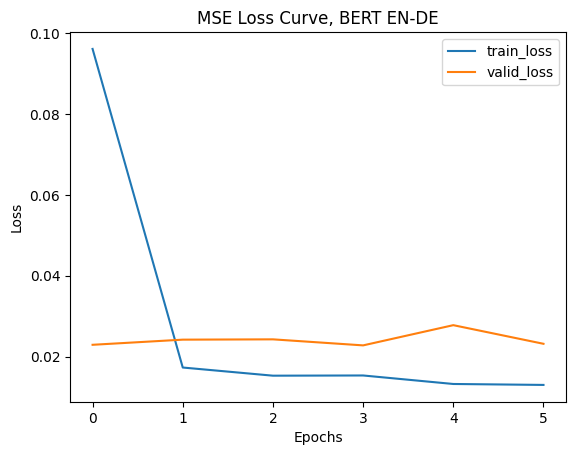

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
train_log = pd.read_csv(f'loss{qlora_string}_{lang}_{rank}.csv')
train_log[['train_loss', 'valid_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'MSE Loss Curve, BERT{f" QLoRA (rank {rank}) " if qlora_enabled else " "}{lang.upper()}')
#plt.show()
plt.savefig(f'loss{qlora_string}_{lang}_{rank}.png')

## Run both models on `test.csv`

### CometKiwi model

In [16]:
test_df["src"] = test_df["original"]
test_df["mt"] = test_df["translation"]
test_input = list(test_df[["src", "mt"]].iloc[i].to_dict() for i in range(test_df.shape[0]))
result = model.predict(test_input, batch_size=batch_size, gpus=1);
comet_kiwi_results = torch.tensor(result.scores, dtype = torch.float32)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadloc

### Bert Model

In [17]:
result = []
bert_model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        result.append(bert_model(**batch))
bert_results = torch.cat([i.logits for i in result]).T.squeeze().cpu()

In [18]:
# save test results
import pickle

# Save the object to a file
with open(f'test_predictions_{qlora_string}_{lang}_{rank}.pkl', 'wb') as f:
    pickle.dump(bert_results, f)

with open(f'test_predictions_cometkiwi_{lang}.pkl', 'wb') as f:
    pickle.dump(comet_kiwi_results, f)

In [11]:
# load bert predictions
import pickle

with open('test_predictions__original_en-zh.pkl', 'rb') as file:
    bert_results = pickle.load(file)

In [18]:
# Original data
baseline_results = torch.Tensor(test_df["mean"].values)
# Calculate Mean Squared Error on normalized values 
mean_squared_test_error = ((comet_kiwi_results - baseline_results) ** 2).mean().item()
print(f"Mean Squared Test Error CometKiwi predictions(Normalized {lang.upper()}): {mean_squared_test_error}")

Mean Squared Test Error CometKiwi predictions(Normalized EN-DE): 0.014457996003329754


In [19]:
mean_squared_test_error = ((bert_results - baseline_results) ** 2).mean().item()
print(f"Mean Squared Test Error QLORABERT predictions(Normalized {lang.upper()}): {mean_squared_test_error}")

Mean Squared Test Error QLORABERT predictions(Normalized EN-DE): 0.01977568119764328


### Spearman Correlation

In [20]:
import scipy.stats as stats

correlation, p_value = stats.spearmanr(baseline_results, bert_results)

print(f'QLORABERT:{lang.upper()}')
print(f"Spearman correlation)", correlation)
print("P-value:", p_value)

QLORABERT:EN-DE
Spearman correlation) 0.1474376558244671
P-value: 2.9043476245668703e-06


In [21]:
import scipy.stats as stats

correlation, p_value = stats.spearmanr(baseline_results, comet_kiwi_results)

print(f'CometKiwi:{lang.upper()}')
print(f"Spearman correlation)", correlation)
print("P-value:", p_value)

CometKiwi:EN-DE
Spearman correlation) 0.5715374997243639
P-value: 1.2795940899792793e-87


In [22]:
correlation, p_value = stats.spearmanr(bert_results, comet_kiwi_results)

print(f'BERT vs CometKiwi:{lang.upper()}')
print(f"Spearman correlation)", correlation)
print("P-value:", p_value)

BERT vs CometKiwi:EN-DE
Spearman correlation) 0.2633109878761894
P-value: 2.7303553428564908e-17


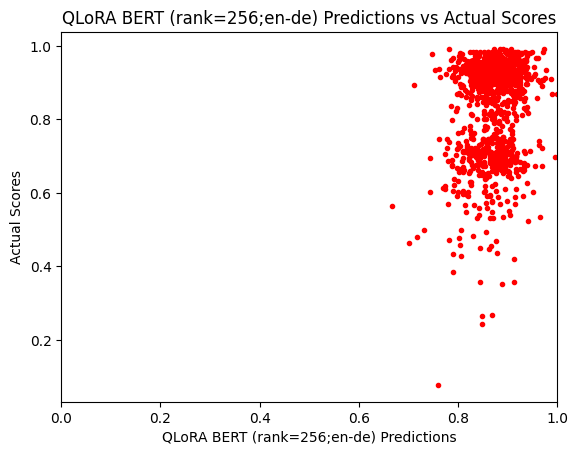

In [23]:
import matplotlib.pyplot as plt
plt.scatter(bert_results, baseline_results, marker='.', c='red')
plt.xlim([0, 1])
plt.xlabel(f'QLoRA BERT (rank={rank};{lang}) Predictions')
#plt.xlabel(f'BERT Predictions ({lang})')
plt.ylabel('Actual Scores')
plt.title(f'QLoRA BERT (rank={rank};{lang}) Predictions vs Actual Scores')
#plt.title(f'BERT Predictions vs Actual Scores ({lang})')
plt.savefig(f'scatter_{qlora_string}_{lang}_{rank}')
#plt.savefig(f'scatter_{qlora_string}_{lang}')

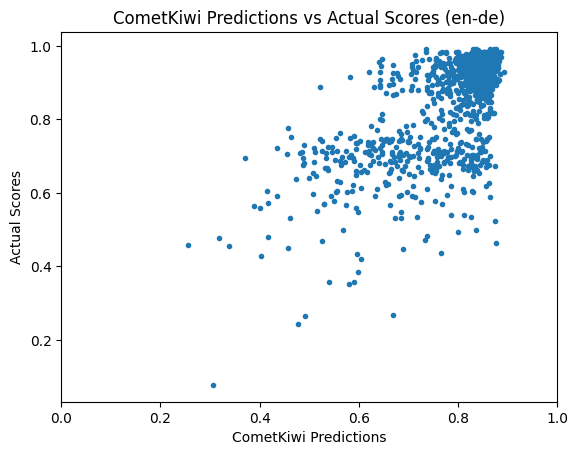

In [24]:
plt.scatter(comet_kiwi_results, baseline_results, marker='.')
plt.xlim([0, 1])
plt.xlabel('CometKiwi Predictions')
plt.ylabel('Actual Scores')
plt.title(f'CometKiwi Predictions vs Actual Scores ({lang})')
plt.savefig(f'scatter_cometkiwi_{lang}')

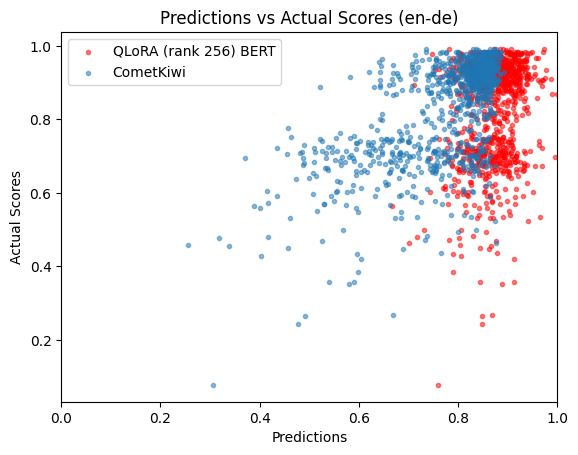

In [25]:
import matplotlib.pyplot as plt
plt.scatter(bert_results, baseline_results, marker='.', c='red', alpha=0.5)
plt.scatter(comet_kiwi_results, baseline_results, marker='.', alpha=0.5)
plt.xlim([0, 1])
plt.xlabel('Predictions')
plt.ylabel('Actual Scores')
plt.title(f'Predictions vs Actual Scores ({lang})')
plt.legend([f'QLoRA (rank {rank}) BERT','CometKiwi'])
#plt.legend([f'BERT','CometKiwi'])
plt.savefig(f'scatter_predvsGT_{qlora_string}_{rank}_{lang}')
#plt.savefig(f'scatter_predvsGT_{qlora_string}_{lang}')

(array([  2.,   3.,  11.,  70., 178., 310., 289., 109.,  21.,   5.]),
 array([0.66664594, 0.70237201, 0.73809803, 0.7738241 , 0.80955017,
        0.84527624, 0.88100225, 0.91672832, 0.95245439, 0.9881804 ,
        1.02390647]),
 <BarContainer object of 10 artists>)

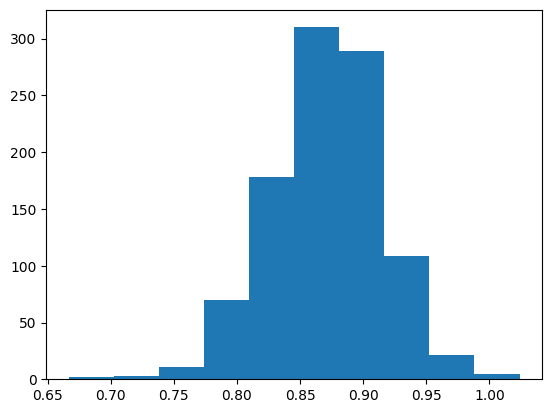

In [38]:
plt.hist(bert_results)

(0.0, 1.0)

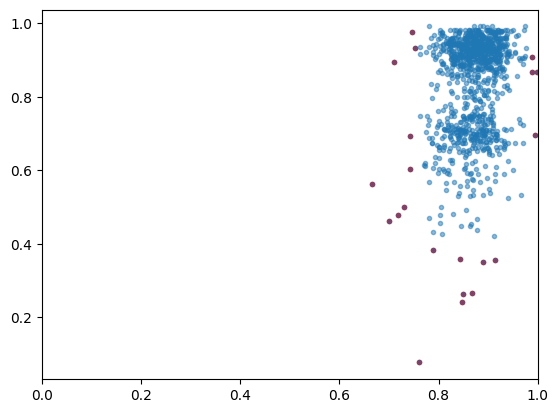

In [63]:
import numpy as np

def get_outliers_iqr(data):
    """Detects outliers in a list of values using the IQR method."""

    data = np.array(data)
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = np.where((data < lower_bound) | (data > upper_bound))
    return outliers

def get_outliers(x,y):
    outliers_x = get_outliers_iqr(x)
    outliers_y = get_outliers_iqr(y)
    outliers = np.hstack((outliers_x,outliers_y)).squeeze()
    return outliers

outliers = get_outliers(bert_results, baseline_results)
plt.scatter(bert_results[outliers], baseline_results[outliers], marker='.', c='red', alpha=1)
plt.scatter(bert_results, baseline_results, marker='.', alpha=0.5)
plt.xlim([0, 1])

In [105]:
import re
for i in range(len(test_dataloader.dataset[outliers]['input_ids'])):
    s = tokenizer.decode(test_dataloader.dataset[outliers]['input_ids'][i])
    s = re.sub(r'\[PAD\]', '', s).strip()
    print(s)
    print(bert_results[outliers[i]])
    print(test_dataloader.dataset[outliers]['labels'][i])
    print()

[CLS] the barnstormers currently play in the indoor football league. [SEP] die barnstormers spielen derzeit in der indoor football league. [SEP]
tensor(0.9992)
tensor(0.8687)

[CLS] dna replication prokaryotic dna replication processivity [SEP] dna - replikation prokaryotische dna - replikation prozess [SEP]
tensor(0.7105)
tensor(0.8939)

[CLS] interpreting serials, in his the limits of interpretation, pp. [SEP] interpreting serials, in seinem the limits of interpretation, pp. [SEP]
tensor(0.7429)
tensor(0.6027)

[CLS] roman army researches band 12 ), steiner, stuttgart, 2000,. [SEP] roman army researches band 12 ), steiner, stuttgart, 2000,. [SEP]
tensor(0.7310)
tensor(0.5000)

[CLS] during lindwall ' s sixth over, weekes missed an attempted hook shot after hesitating. [SEP] wahrend lindwalls sechsten vorbei, wochenende verpasste einen versuch haken schuss nach zogern. [SEP]
tensor(0.7431)
tensor(0.6936)

[CLS] wambach attended our lady of mercy high school in rochester from 1994 to 1

(array([  3.,   2.,   8.,  19.,  36.,  46.,  84., 107., 242., 451.]),
 array([0.25630516, 0.31992173, 0.38353831, 0.44715491, 0.51077145,
        0.57438803, 0.63800466, 0.70162123, 0.76523781, 0.82885438,
        0.89247096]),
 <BarContainer object of 10 artists>)

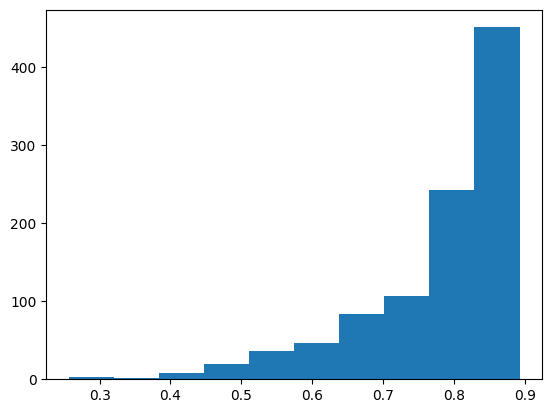

In [39]:
plt.hist(comet_kiwi_results)

(array([  1.,   1.,   2.,   8.,  19.,  46., 166., 104., 170., 481.]),
 array([0.07744107, 0.16885522, 0.26026937, 0.3516835 , 0.44309765,
        0.5345118 , 0.62592596, 0.71734005, 0.80875421, 0.90016836,
        0.99158251]),
 <BarContainer object of 10 artists>)

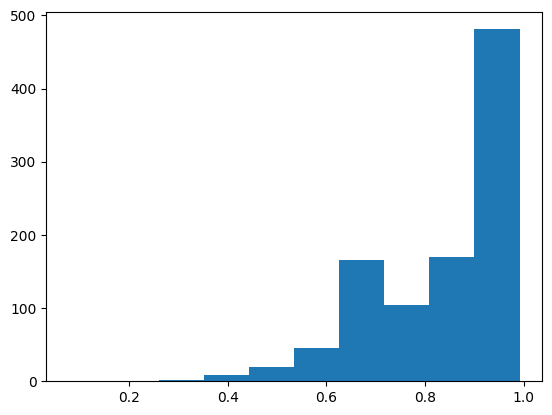

In [40]:
plt.hist(baseline_results)

In [26]:
result = []
bert_model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        result.append(bert_model(**batch))
bert_results = torch.cat([i.logits for i in result]).T.squeeze().cpu()

NameError: name 'testloader' is not defined

QLORABERT:RU-EN                                Comet-kiwi
Spearman correlation) 0.5259149313434294       0.7565838633110321
P-value: 3.266896375562134e-72                 2.5188016107389757e-186